This follows Elliot's idea for a contrast:

> **proposal 1**
> 
> Two class (e.g., CorrectStop vs. CorrectGo)
> 
> Leave-One-Out classifier...
> 
> Neural similarity of a subject to the group with a Stop vs. Go contrast might actually be indicative of performance.
> 
> subjects will naturally differ across the task as to how much their average signal responds to that, and the ones with better response might have better response inhibition.

So there are a couple of steps here...

1. iterate through subjects, holding out one at a time, and do the following steps.
2. Train a classifier across all the training subjects, classifying Stop vs. Go. We can start with the beta averages since those have done so well.
3. Use that classifier as a 'neural signature' to measure Stop. No real need to go to the betaseries--just see the extent to which each subject's Stop response matches the group's.
4. After you've iterated through all subjects, you have a measure of response inhibition for each subject. See if that regresses onto SST_SSRT or any of our other measures of response inhibition.




As a first pass, we can simplify this a bit just trying that single classifier on all subjects. This means that we're using train for tes tset but it will give us an initial measure of feasibility.

We probably do need to restrict to a specific brain region though, and that means retraining. - I think that prefrontal cortex mask we have works well.

## Data already generated

Can we use data already generated in `SST_inhibition_cv.ipynb`?

In [1]:
import pickle
from IPython.core.display import display, HTML, Markdown

In [7]:
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [8]:
results_filepath=ml_data_folderpath + "/SST/train_test_results_conditions_40subs_twoclasses.pkl"

In [9]:
results_2c = pickle.load(open(results_filepath,'rb'))

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "



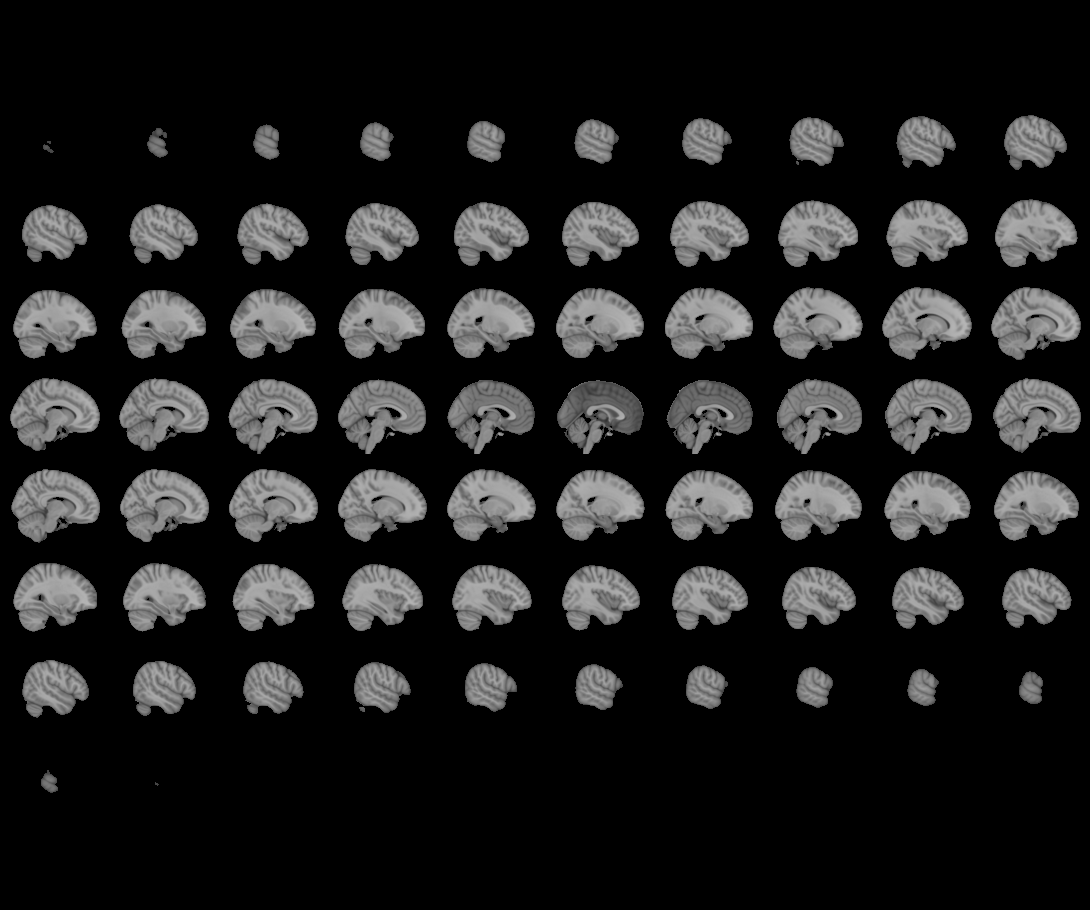
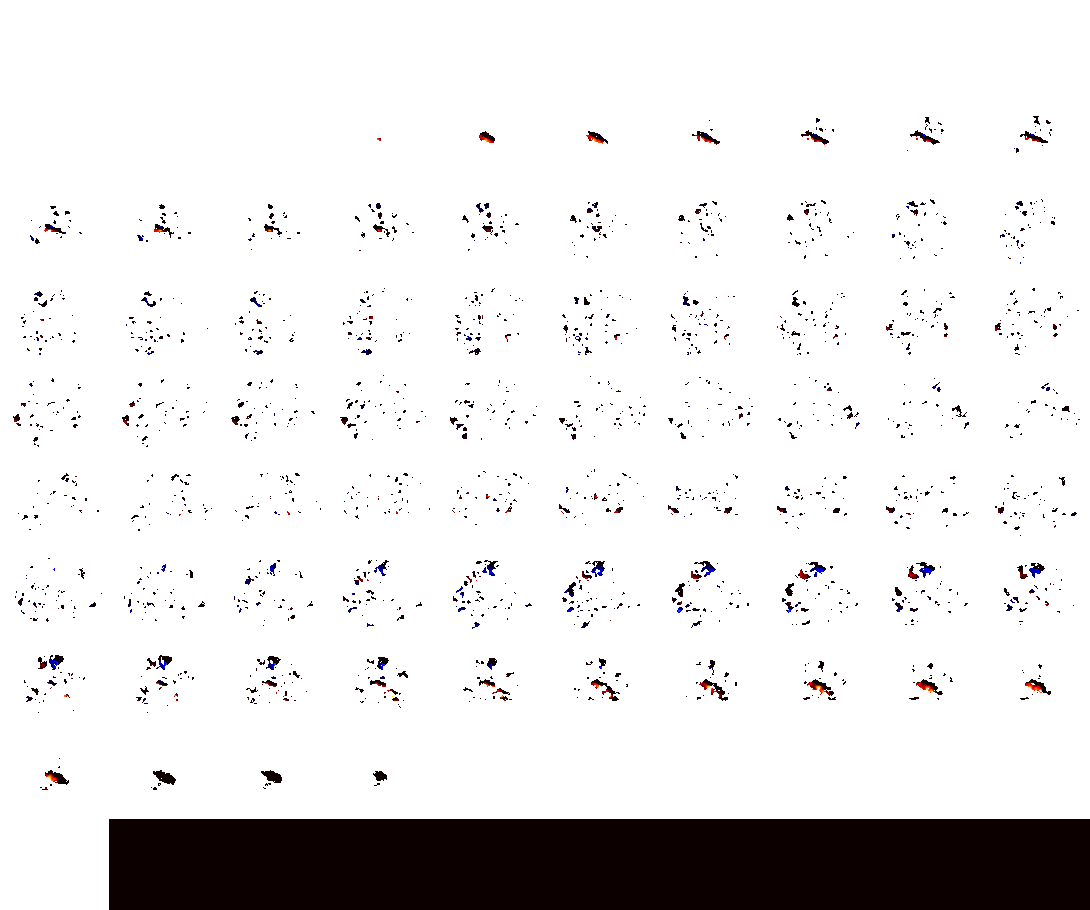

In [10]:
from nilearn import plotting
from nilearn.masking import compute_brain_mask
import nltools as nlt

plotting.view_img(results_2c[3]['CorrectGo'],threshold=0.0002)

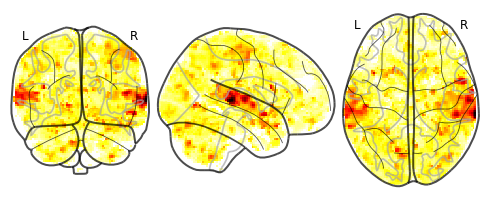

In [11]:
plotting.plot_glass_brain(results_2c[3]['CorrectGo'])


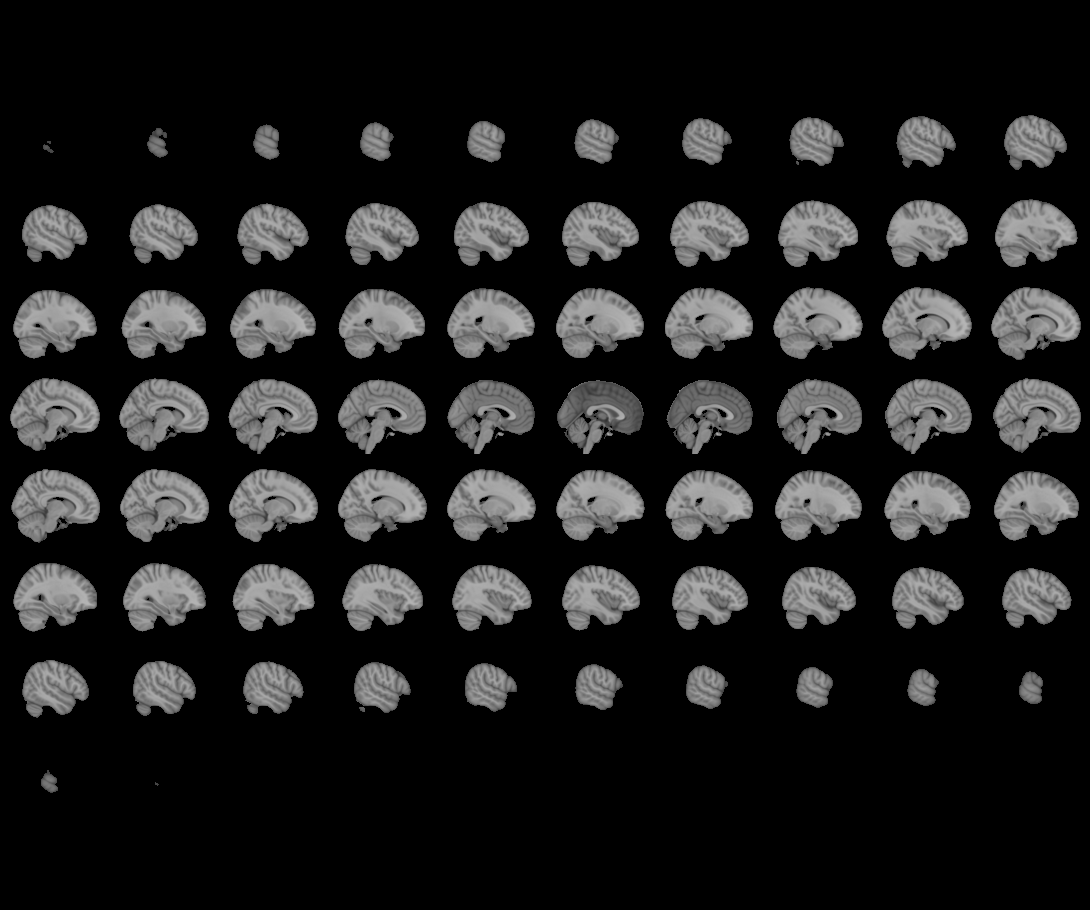
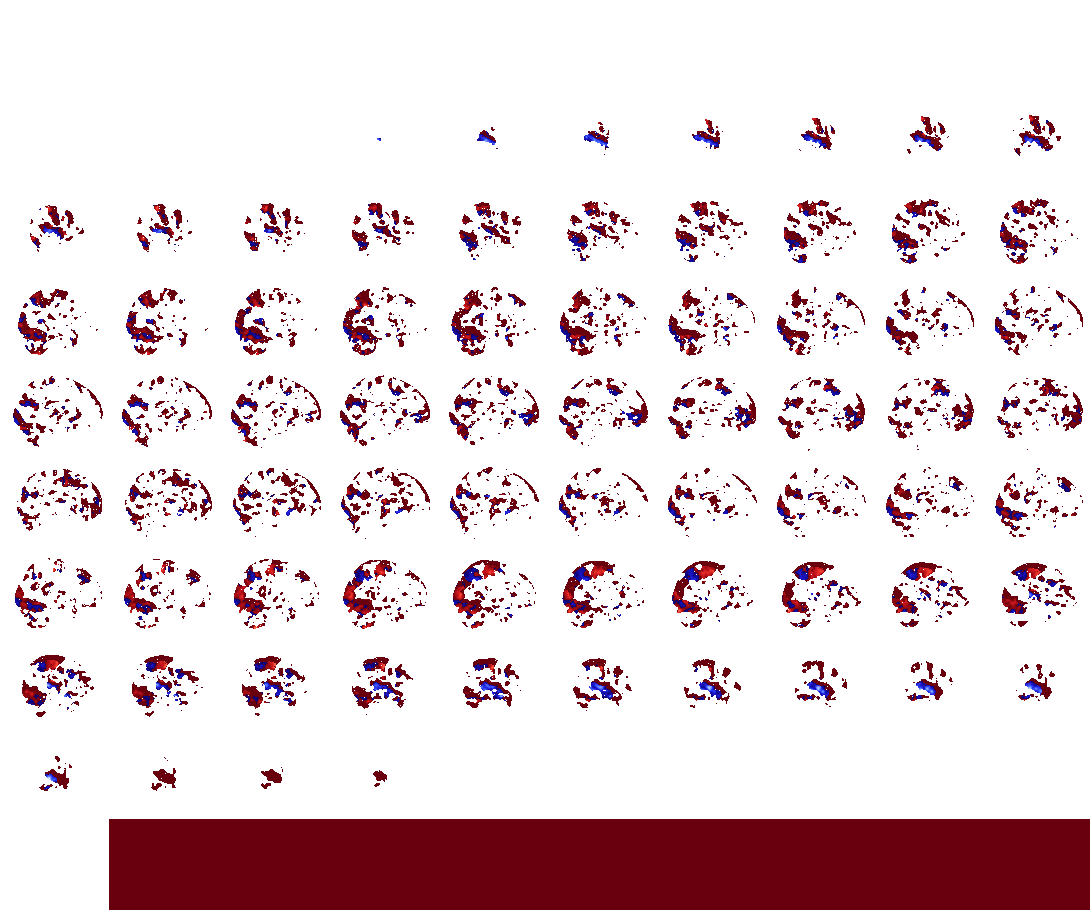

In [12]:
plotting.view_img(results_2c[3]['CorrectStop'],cmap='blue_red')

In [13]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


Not quite--we need a PFC mask I think. But we can use the script already written to do that.

## Setup

In [14]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



python initialized for apply_loocv_and_save
4


## 2-class classification with PFC mask

In [15]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)

In [10]:

def condition_resp_trans_func(X):
    return(X.condition_label)


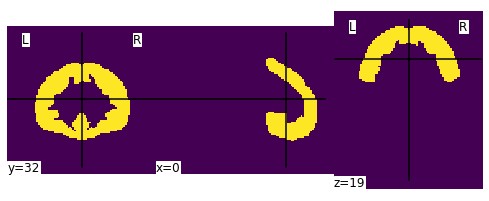

In [11]:
from nilearn import plotting
plotting.plot_img(pfc_mask)

In [12]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_58subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

In [13]:
#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_pfcmask.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

In [15]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func,
        mask=pfc_mask
    )

In [16]:
results=pickle.load(open(results_filepath,'rb'))


In [17]:
np.mean(results[0])

0.8641975308641975

In [18]:
results[3]

{'CorrectGo': <nibabel.nifti1.Nifti1Image at 0x2aaaedfd99a0>,
 'CorrectStop': <nibabel.nifti1.Nifti1Image at 0x2aaaedfd9b80>}


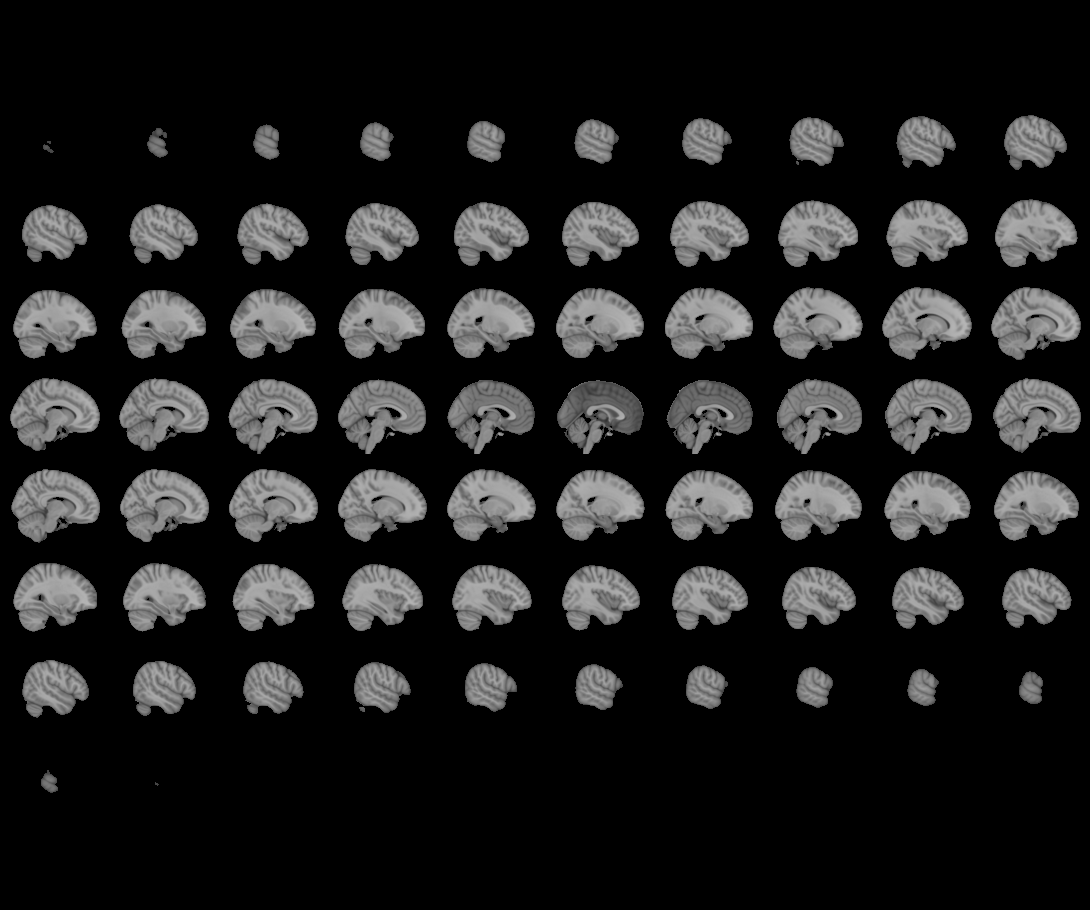
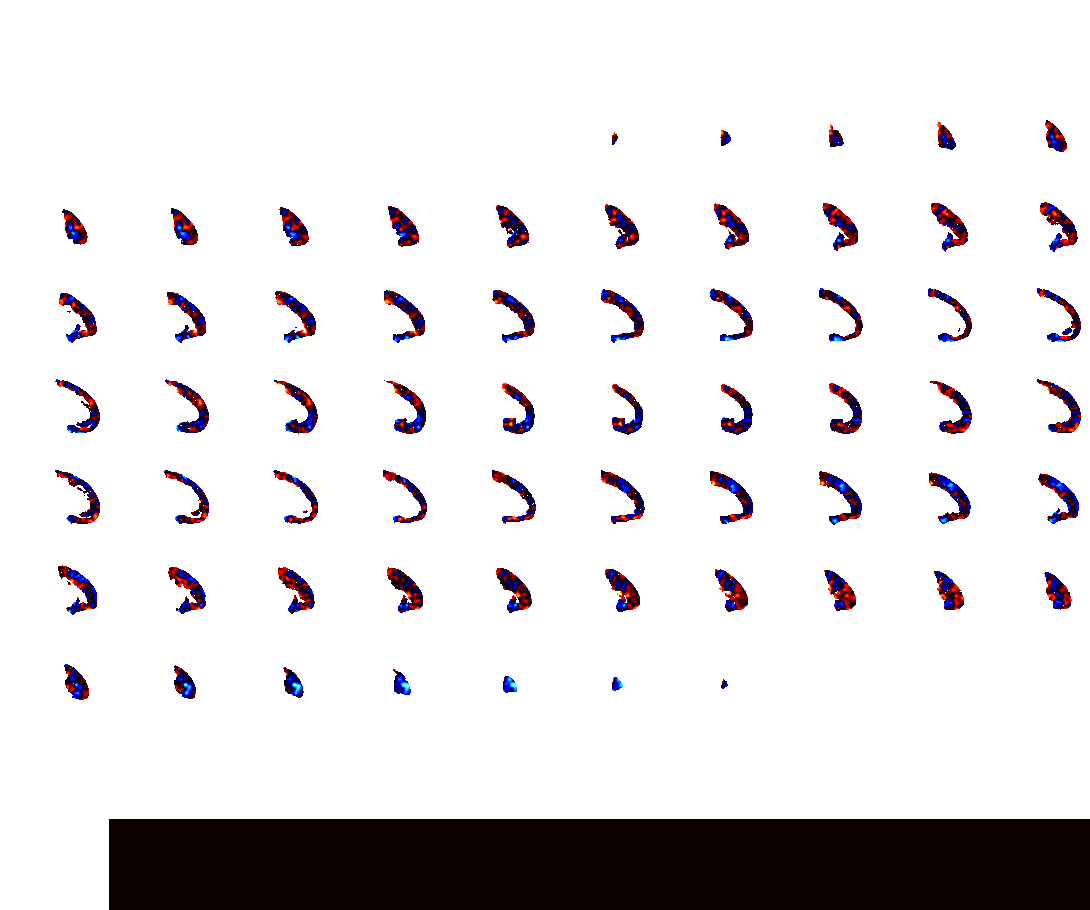

In [19]:
correct_stop_ns=results[3]['CorrectStop']
plotting.view_img(correct_stop_ns,
    cmap='cold_hot')

In [20]:
vis_thresh = 0.0002

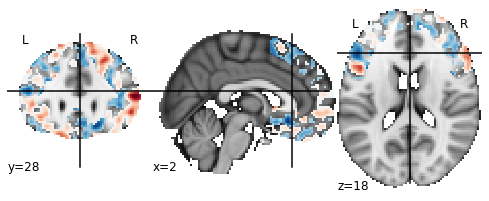

In [21]:
plotting.plot_img(correct_stop_ns,
    threshold=vis_thresh,
    cmap='RdBu',
    bg_img=background_img)

In [22]:
from nilearn import surface
from nilearn import datasets
from nilearn import plotting
fsaverage = datasets.fetch_surf_fsaverage()

texture_left = surface.vol_to_surf(correct_stop_ns, fsaverage.pial_left)
texture_right = surface.vol_to_surf(correct_stop_ns, fsaverage.pial_right)

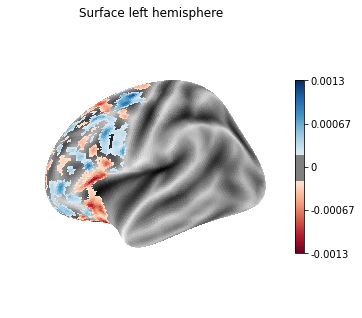

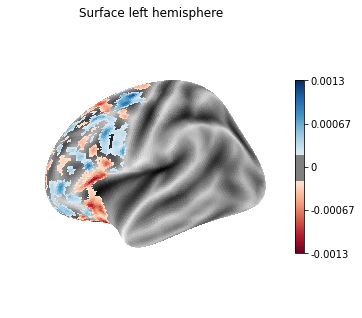

In [23]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left',
                            title='Surface left hemisphere', colorbar=True,
                            threshold=vis_thresh, bg_map=fsaverage.sulc_left,cmap='RdBu')

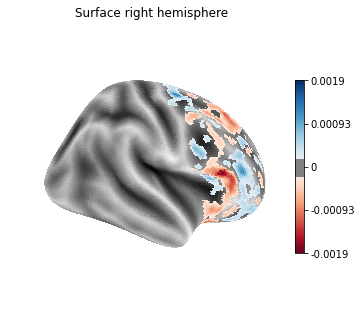

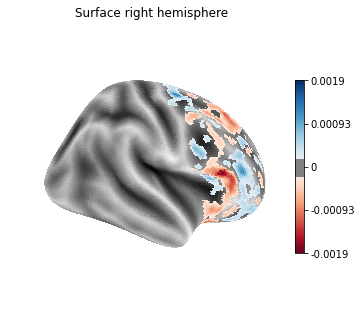

In [24]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right',
                            title='Surface right hemisphere', colorbar=True,
                            threshold=vis_thresh, bg_map=fsaverage.sulc_right,cmap='RdBu')

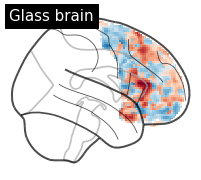

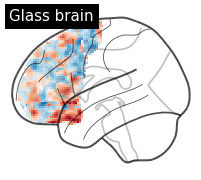

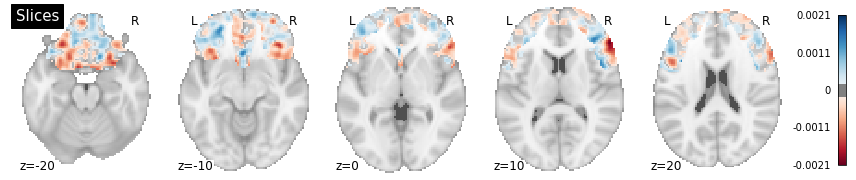

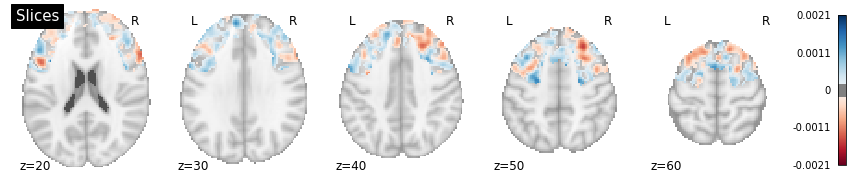

In [25]:
plotting.plot_glass_brain(correct_stop_ns, display_mode='r', plot_abs=False,
                          title='Glass brain', threshold=vis_thresh,cmap='RdBu')

plotting.plot_glass_brain(correct_stop_ns, display_mode='l', plot_abs=False,
                          title='Glass brain', threshold=vis_thresh,cmap='RdBu')

plotting.plot_stat_map(correct_stop_ns, display_mode='z', threshold=vis_thresh,
                       cut_coords=range(-20, 21, 10), title='Slices',cmap='RdBu')
plotting.plot_stat_map(correct_stop_ns, display_mode='z', threshold=vis_thresh,
                       cut_coords=range(20, 61, 10), title='Slices',cmap='RdBu')

Now we use this nifti image as a neural signature to measure 'stop' in each subject. So that means we go back to the brain data, and classify each beta for each subject's fit to the CorrectStop neural signature.

Remember here, each beta corresponds to ALL activity of a particular type for each subject.

In [26]:
bd=pickle.load(open(brain_data_filepath,'rb'))


In [27]:
bd_correctStop=bd[bd.X.condition_label=="CorrectStop"]

In [28]:
correct_stop_similarity = bd.apply_mask(pfc_mask).similarity(correct_stop_ns)
bd.X['CS_similarity'] = correct_stop_similarity


In [29]:
bd.X.groupby('condition_label').agg({'CS_similarity':"mean"})

CS_similarity
condition_label               
CorrectGo             0.103523
CorrectStop           0.010555

So far so good! 

In [30]:
bd.X

condition_index condition_label  \
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
..              ...             ...   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   

                             raw_beta_description           beta subject  \
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV005   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV005   
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV006   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV006   
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV010   
..                                            ...            ...     ...   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV216   
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV217   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV217   
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV218   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV218   

    wave  CS_similarity  
0      1       0.036635  
1      1       0.035972  
0      1       0.109364  
1      1       0.036907  
0      1       0.073130  
..   ...            ...  
1      1      -0.039040  
0      1       0.108045  
1      1      -0.010278  
0      1       0.138326  
1      1       0.059533  

[162 rows x 7 columns]

In [31]:
bd.X[['subject','condition_label','CS_similarity']]

subject condition_label  CS_similarity
0   DEV005       CorrectGo       0.036635
1   DEV005     CorrectStop       0.035972
0   DEV006       CorrectGo       0.109364
1   DEV006     CorrectStop       0.036907
0   DEV010       CorrectGo       0.073130
..     ...             ...            ...
1   DEV216     CorrectStop      -0.039040
0   DEV217       CorrectGo       0.108045
1   DEV217     CorrectStop      -0.010278
0   DEV218       CorrectGo       0.138326
1   DEV218     CorrectStop       0.059533

[162 rows x 3 columns]

In [32]:
bd_to_plot = bd.X[['condition_label','CS_similarity','subject']].pivot(index='subject',columns='condition_label',values='CS_similarity').reset_index()

In [33]:
from matplotlib import pyplot

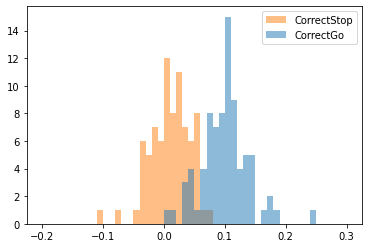

In [34]:
bins=np.linspace(-0.2,0.3,51) #create histogram bins
pyplot.hist(
    bd_to_plot[['CorrectGo','CorrectStop']]#.to_numpy()
    ,bins=bins
    ,alpha=0.5,histtype='stepfilled',label=['CorrectGo','CorrectStop'])
pyplot.legend(prop={'size': 10})

In [35]:
bd_to_plot[['CorrectGo','CorrectStop']]

condition_label  CorrectGo  CorrectStop
0                 0.036635     0.035972
1                 0.109364     0.036907
2                 0.073130     0.007721
3                 0.044833    -0.023136
4                 0.098908    -0.015626
..                     ...          ...
76                0.085655    -0.017507
77                0.102493     0.036534
78                0.015812    -0.039040
79                0.108045    -0.010278
80                0.138326     0.059533

[81 rows x 2 columns]

Looks very good. I wonder if those are correlated, too?...never mind, let's just keep trying.

One puzzling thing: we're supposed to be measuring CorrectStop, but the similarity score is higher for CorrectGo. Why would that be?

Let's see what the result looks like for CorrectGo.
    

In [36]:
correct_go_ns=results[3]['CorrectGo']
correct_go_similarity = bd.apply_mask(pfc_mask).similarity(correct_go_ns)
bd.X['CG_similarity'] = correct_go_similarity

In [37]:
bd.X.groupby('condition_label').agg({'CG_similarity':"mean"})

CG_similarity
condition_label               
CorrectGo            -0.103523
CorrectStop          -0.010555

In [38]:
bd.X.loc[:,['CG_similarity','CS_similarity']]

CG_similarity  CS_similarity
0       -0.036635       0.036635
1       -0.035972       0.035972
0       -0.109364       0.109364
1       -0.036907       0.036907
0       -0.073130       0.073130
..            ...            ...
1        0.039040      -0.039040
0       -0.108045       0.108045
1        0.010278      -0.010278
0       -0.138326       0.138326
1       -0.059533       0.059533

[162 rows x 2 columns]

hmm ok they're actually just inverses of each other. But also...

In [39]:
HTML(pd.DataFrame(bd.X.groupby('condition_label').agg({
    'CG_similarity':"mean",
    'CS_similarity':"mean"})).to_html())

'CorrectStop' events are generally not particularly similar; generally uncorrelated with CGSimiliarity or CSSimilarity. 

In other words, we have a "CorrectStop" and a "CorrectGo" signature trained. But the CorrectGo signature seems to be trained _against_ CorrectGo, while the CorrectStop is trained _in favour_ of recognizing.

So both _signatures_ are working. But each signature mainly works by tracking activity in the _CorrectGo_ condition and not responding to the _CorrectStop_ condition.

However, below, we are definitely just looking at CorrectStop neural signature scores, and still get a good result. But we might be measuring mostly the extent to which a CorrectStop beta resembles CorrectGo signal. Higher is stronger...

In [40]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1
#individual_differences['wave'] = individual_differences['wave'].astype(object) # for compatibility with the wave column in the dataset

In [41]:
individual_differences

subject  cancer_promoting_minus_preventing_FCI  \
0    DEV001                              -0.134946   
1    DEV002                              -0.541398   
2    DEV004                               0.113978   
3    DEV005                               0.083871   
4    DEV006                               0.430645   
..      ...                                    ...   
195  DEV216                               1.033333   
196  DEV217                              -0.519892   
197  DEV219                               0.702688   
198  DEV250                              -0.358602   
199  DEV280                              -0.825806   

     cancer_promoting_minus_preventing_FFQ  \
0                                -0.113462   
1                                -0.682692   
2                                -0.698077   
3                                 0.321154   
4                                -0.603846   
..                                     ...   
195                              -0.405769   
196                              -0.676923   
197                              -0.280769   
198                              -0.950000   
199                              -0.773077   

     cancer_promoting_minus_preventing_craved_FCI  \
0                                       -0.020430   
1                                       -0.903226   
2                                        0.023656   
3                                        0.044086   
4                                        0.449462   
..                                            ...   
195                                      1.149462   
196                                     -0.559140   
197                                      0.834409   
198                                     -0.520430   
199                                     -0.911828   

     cancer_promoting_minus_preventing_craved_FFQ  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   
..                                            ...   
195                                           NaN   
196                                           NaN   
197                                           NaN   
198                                           NaN   
199                                           NaN   

     cancer_promoting_minus_preventing_liked_FCI  \
0                                      -0.249462   
1                                      -0.179570   
2                                       0.204301   
3                                       0.123656   
4                                       0.411828   
..                                           ...   
195                                     0.917204   
196                                    -0.480645   
197                                     0.570968   
198                                    -0.196774   
199                                    -0.739785   

     cancer_promoting_minus_preventing_liked_FFQ  cancer_promoting_FCI  \
0                                            NaN              2.548387   
1                                            NaN              2.741935   
2                                            NaN              2.580645   
3                                            NaN              2.483871   
4                                            NaN              2.580645   
..                                           ...                   ...   
195                                          NaN              3.000000   
196                                          NaN              2.596774   
197                                          NaN              2.919355   
198                                          NaN              2.758065   
199                                          NaN              2.274194   

     cancer_pr

In [42]:
subject_cs_neural_performance = bd.X.loc[bd.X.condition_label=='CorrectStop',['subject','CS_similarity','CG_similarity']]
subject_cg_neural_performance = bd.X.loc[bd.X.condition_label=='CorrectGo',['subject','CS_similarity','CG_similarity']]

subject_cs_neural_performance.columns = ['CS_trials_' + col for col in subject_cs_neural_performance.columns]
subject_cg_neural_performance.columns = ['CG_trials_' + col for col in subject_cg_neural_performance.columns]
subject_neural_performance = subject_cs_neural_performance.merge(subject_cg_neural_performance,left_on='CS_trials_subject',right_on='CG_trials_subject',how='outer')

In [43]:
subject_neural_performance =subject_neural_performance.rename(columns = {'CS_trials_subject':'subject'})

In [44]:
ind_div_combined = subject_neural_performance.merge(individual_differences,left_on='subject',right_on='subject',how='left')

In [45]:
", ".join(ind_div_combined.columns)

'subject, CS_trials_CS_similarity, CS_trials_CG_similarity, CG_trials_subject, CG_trials_CS_similarity, CG_trials_CG_similarity, cancer_promoting_minus_preventing_FCI, cancer_promoting_minus_preventing_FFQ, cancer_promoting_minus_preventing_craved_FCI, cancer_promoting_minus_preventing_craved_FFQ, cancer_promoting_minus_preventing_liked_FCI, cancer_promoting_minus_preventing_liked_FFQ, cancer_promoting_FCI, cancer_promoting_FFQ, cancer_preventing_FCI, cancer_preventing_FFQ, BSCS, cSES, EDM, BIS_11, PCS, RS, TRSQ, bf_1, weight_0, ACES_abuse, ACES_neglectful_parenting, ACES_sum, ACES_household_dysfunction, ACES_divorced_separated, BFI_agreeableness, BFI_conscientiousness, BFI_extraversion, BFI_neuroticism, BFI_openness, DEMO_mcarthur_social_standing, IMI_value_usefulness, IMI_perceived_choice, IMI_perceived_competence, IMI_effort_importance, IMI_interest_enjoyment, IPAQ_sittinghours, IPAQ_moderateminutes, IPAQ_vigorousminutes, IPAQ_walkingminutes, NCS_get_job_done, NCS_intellectual_task,

In [46]:
from scipy.stats import pearsonr

### CS_trials_CS_similarity

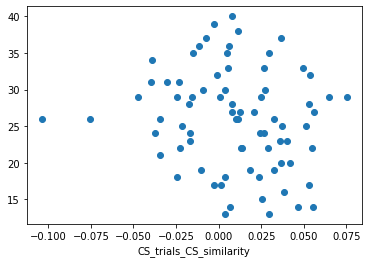

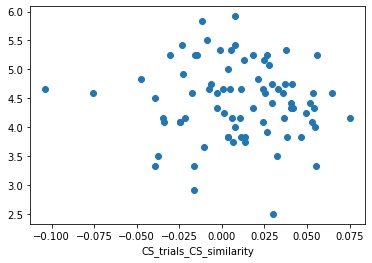

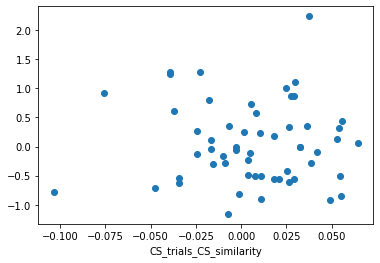

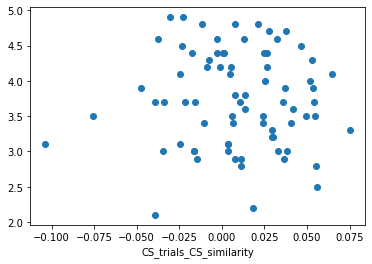

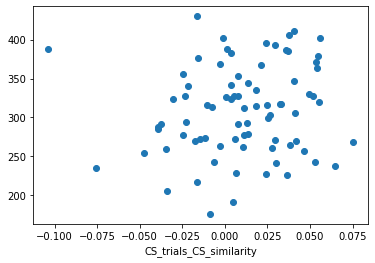

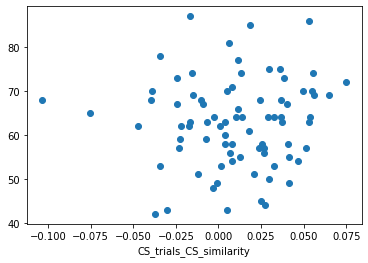

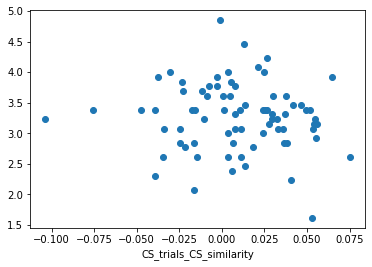

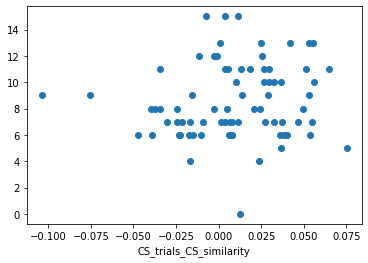

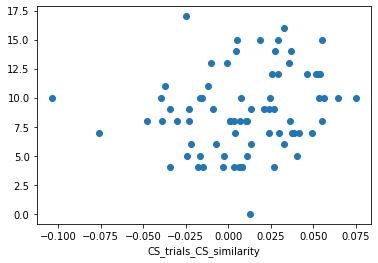

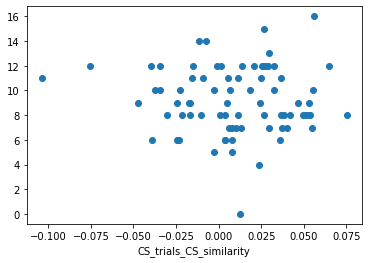

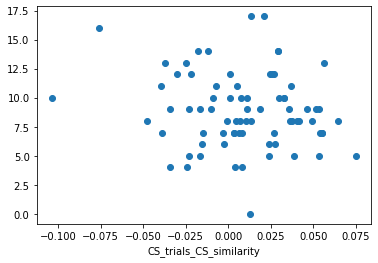

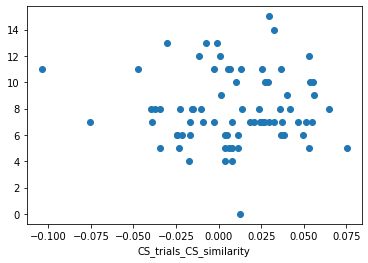

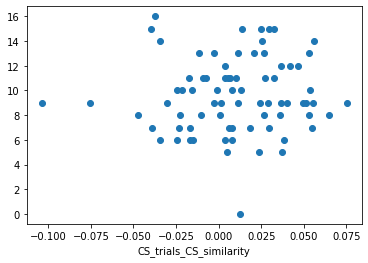

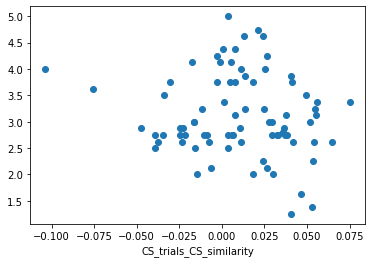

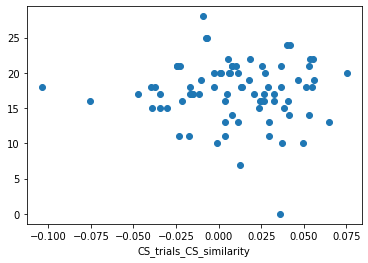

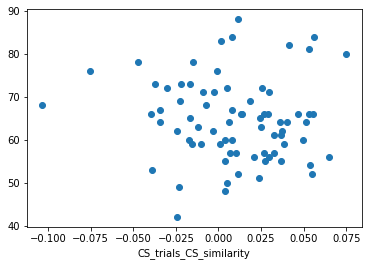

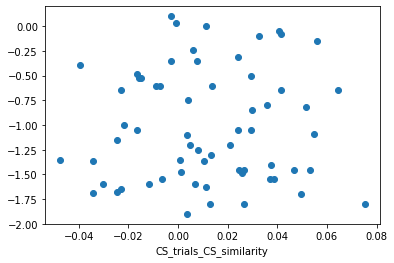

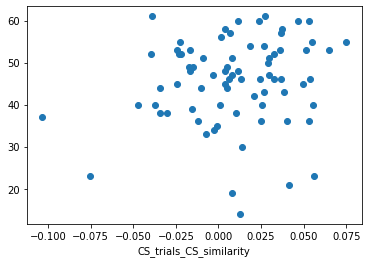

### CG_trials_CG_similarity

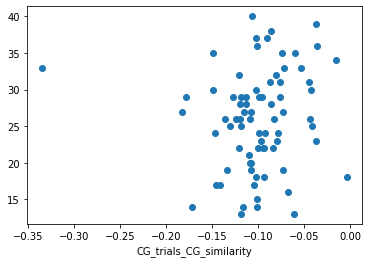

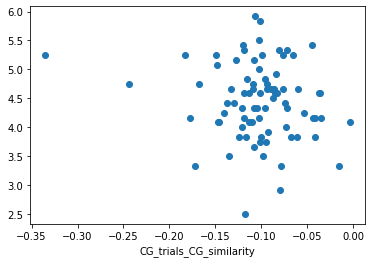

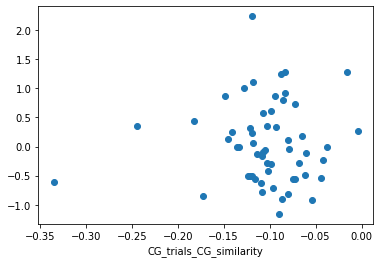

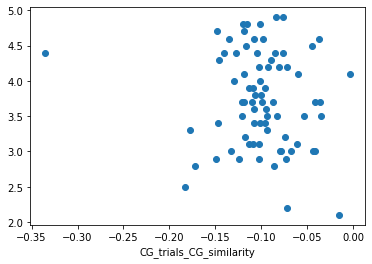

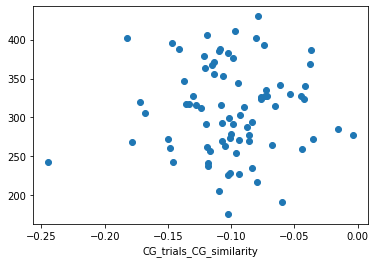

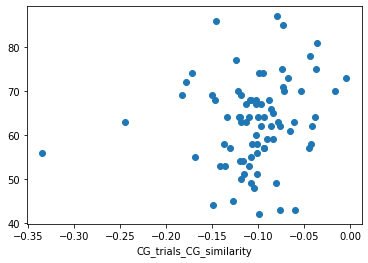

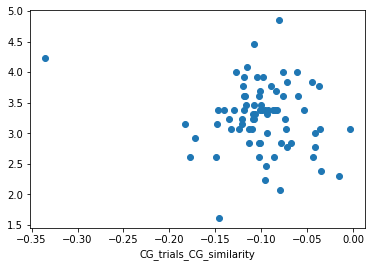

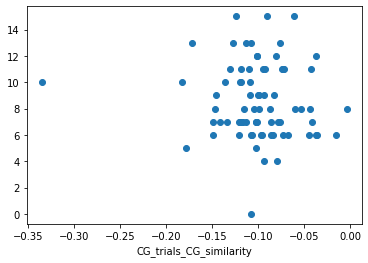

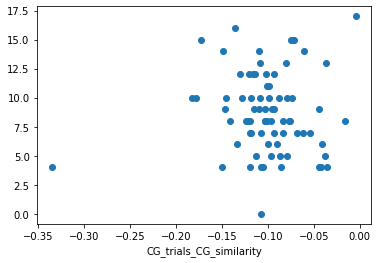

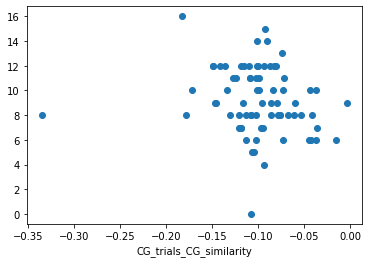

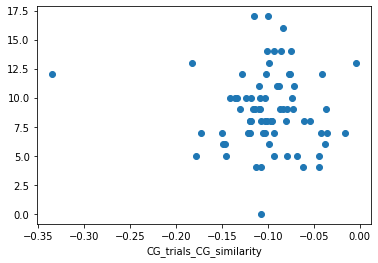

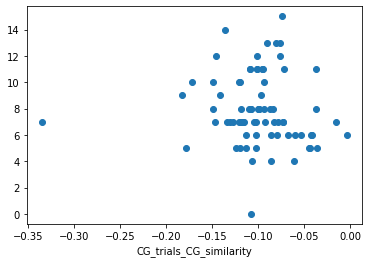

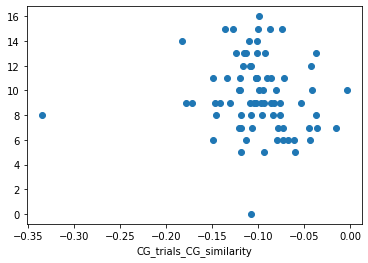

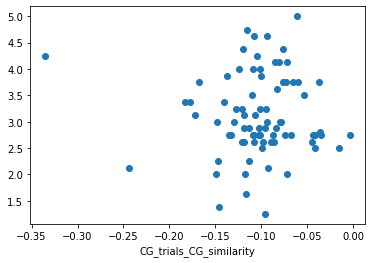

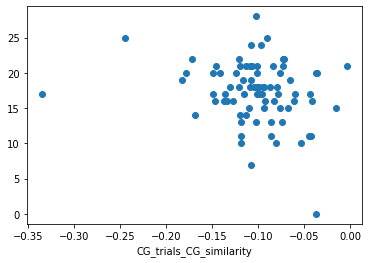

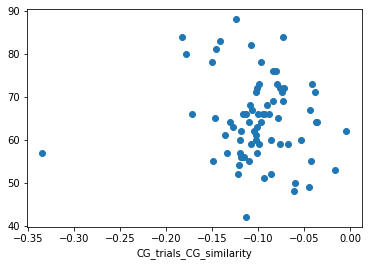

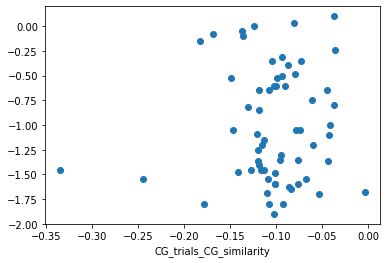

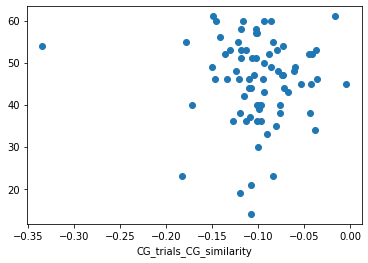

In [47]:
for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        display(HTML(correlate))
        nan_rows = np.isnan(ind_div_combined[correlate])
        cor2way_df = ind_div_combined.loc[nan_rows==False,]
        pearson_result = pearsonr(cor2way_df[neural_var],cor2way_df[correlate])
        display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
        cplot = pyplot.scatter(cor2way_df[neural_var],cor2way_df[correlate])
        cplot.axes.set_xlabel(neural_var)
        cplot.axes.ylabel=correlate
        pyplot.show()

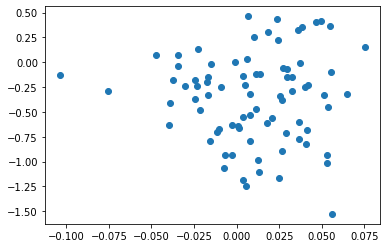

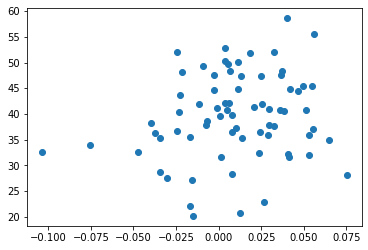

In [48]:
for correlate in ['cancer_promoting_minus_preventing_FFQ','bf_1']:
    display(HTML(correlate))
    nan_rows = np.isnan(ind_div_combined[correlate])
    cor2way_df = ind_div_combined.loc[nan_rows==False,]
    pearson_result = pearsonr(cor2way_df.CS_trials_CS_similarity,cor2way_df[correlate])
    display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
    cplot = pyplot.scatter(cor2way_df.CS_trials_CS_similarity,cor2way_df[correlate])
    pyplot.show()

CS_Similarity is POSITIVELY related to subjects' CorrectStop signal 

Higher body fat percentage is related to CorrectStop resembling the CorrectStop neural signature, which itself actually gives higher scores to the CorrectGo trials:

In [49]:
HTML(pd.DataFrame(bd.X.groupby('condition_label').agg({
    'CG_similarity':"mean",
    'CS_similarity':"mean"})).to_html())

So subjects where CorrectStop more resembles CorrectGo tend to have higher body fat percentage scores??

It might be time to expand the sample size to take in all of our initial subjects--perhaps not the full set we have available, but at least the ~60 we had initially planned to look at.

In [ ]:
from analyze_results import *

### PFC (repeated)

Repeat the PFC analysis above using a more automated pipeline that can be re-applied to other masks.

In [22]:

dataset_name = 'conditions'


brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_pfcmask.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)
relevant_mask = pfc_mask



/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_pfcmask.pkl
0.8641975308641975


### correct_stop_ns

### correct_go_ns

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_pfcmask.pkl
plotting signatures


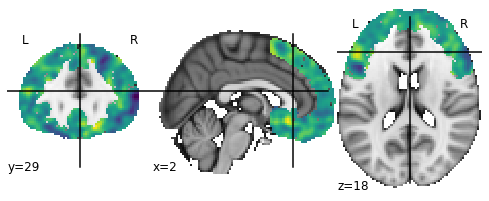

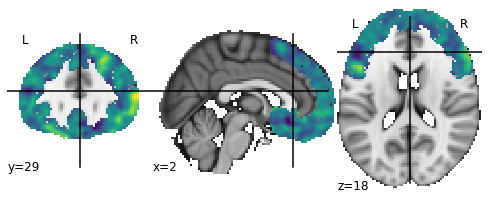

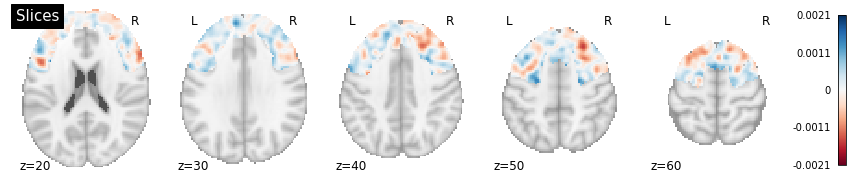

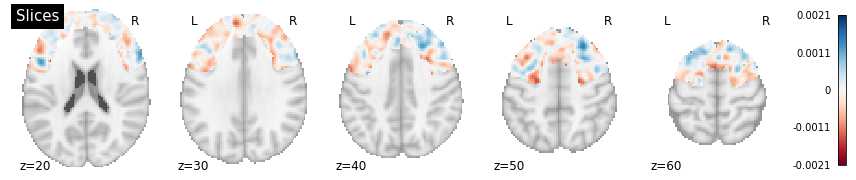

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


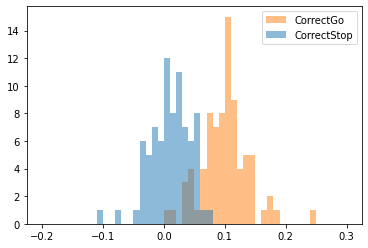

### CS_trials_CS_similarity

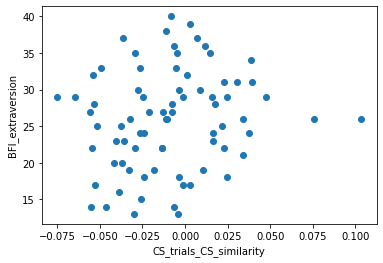

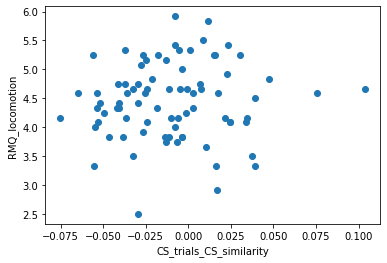

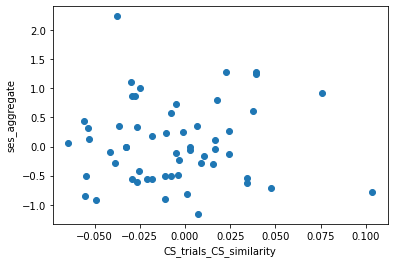

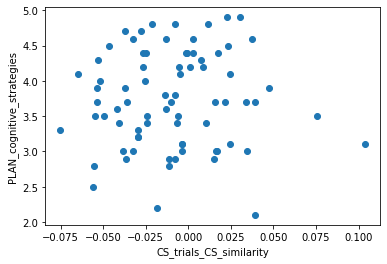

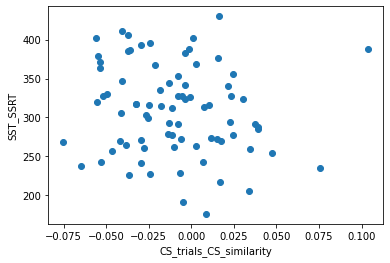

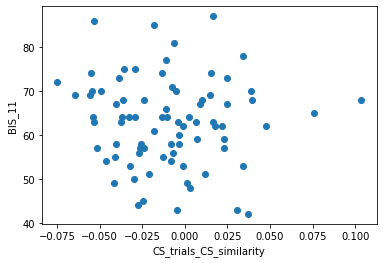

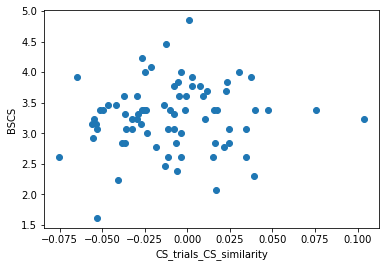

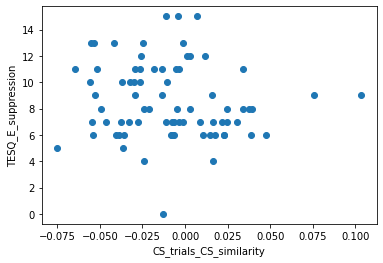

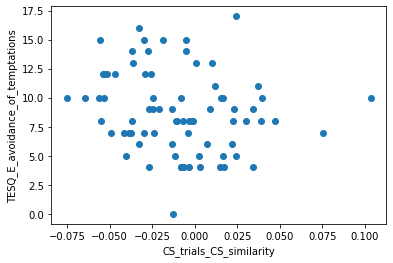

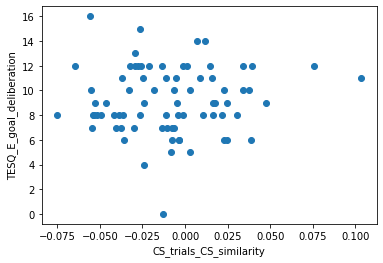

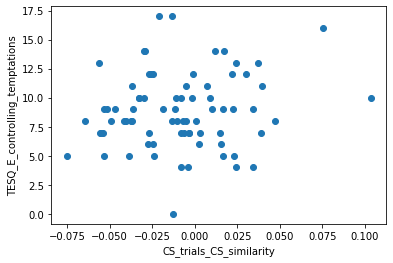

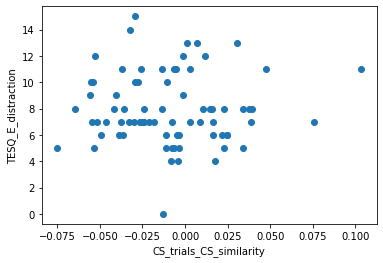

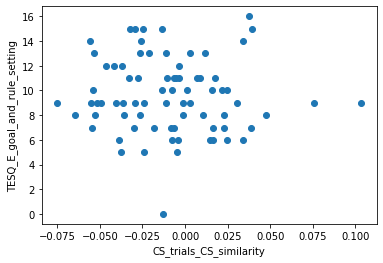

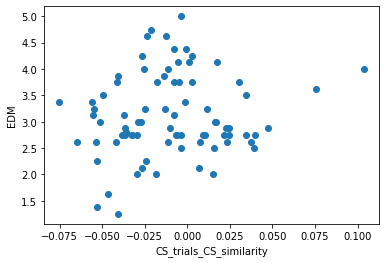

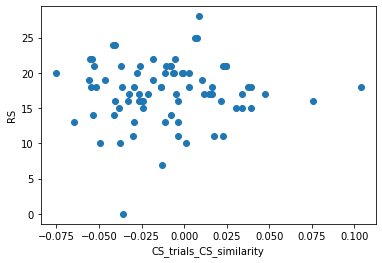

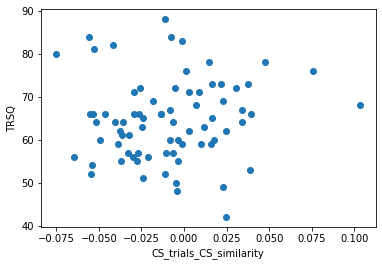

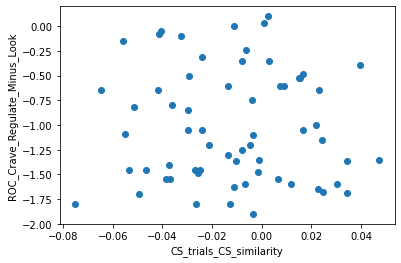

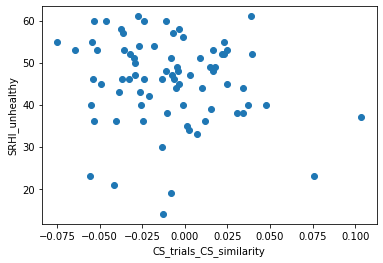

### CG_trials_CG_similarity

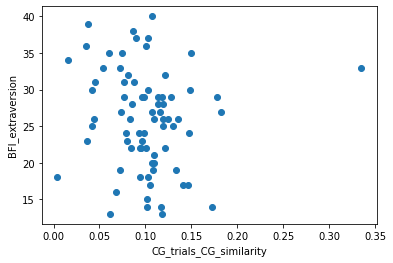

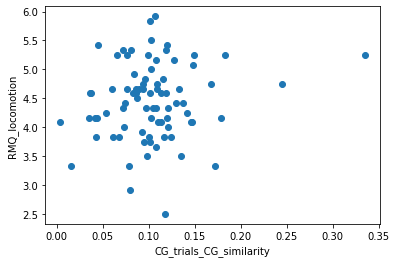

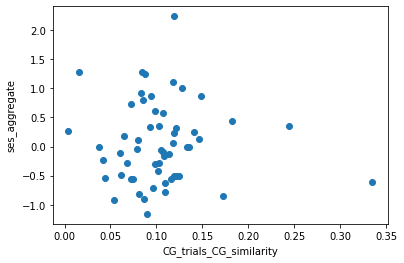

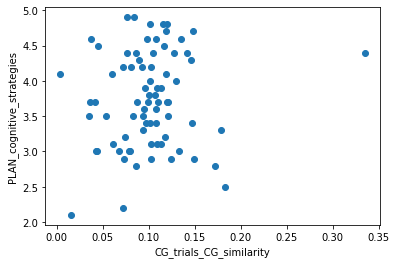

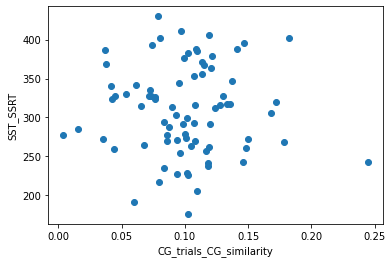

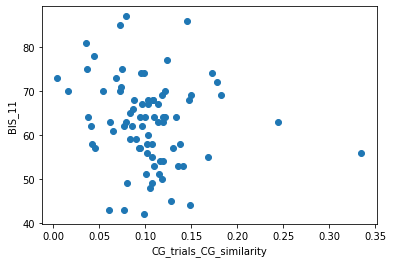

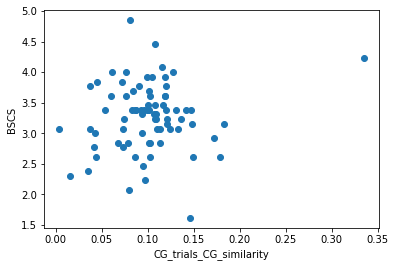

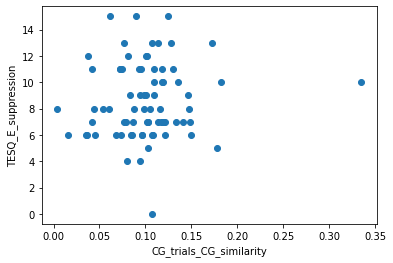

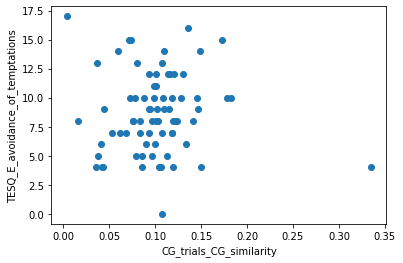

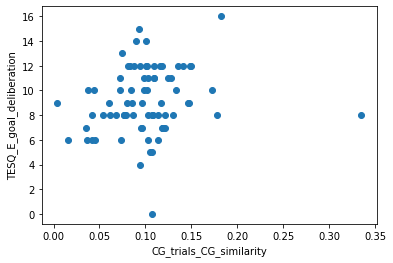

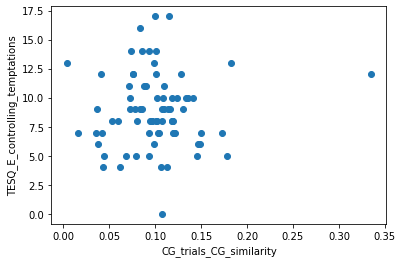

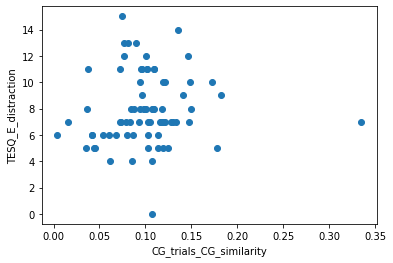

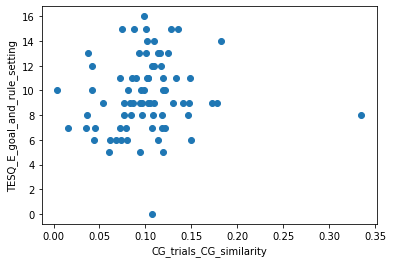

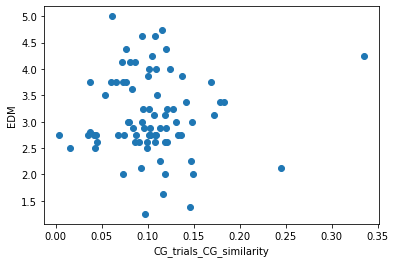

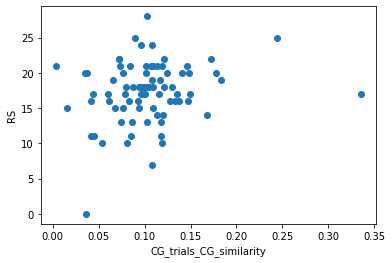

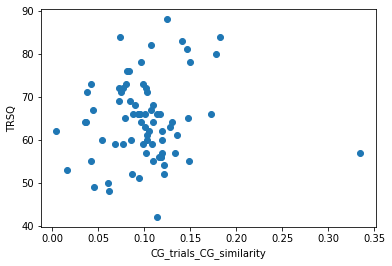

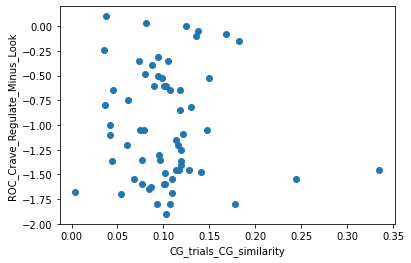

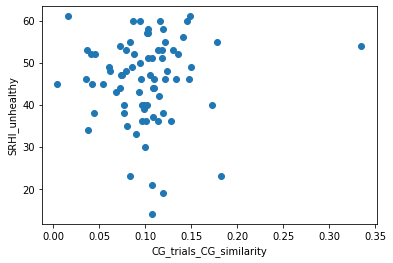

In [23]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func
    )
    
    

print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

results[3]

correct_stop_ns=results[3]['CorrectStop']
display(Markdown("### correct_stop_ns"))
plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

correct_go_ns=results[3]['CorrectGo']
display(Markdown("### correct_go_ns"))
plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(correct_stop_ns,correct_go_ns)

print("loading data")

bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity')

create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)

for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        visualize_corr(neural_var,correlate,ind_div_combined)
        

### whole brain

In [10]:

dataset_name = 'conditions'


In [11]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None

In [12]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func
    )

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_wholebrain.pkl
0.9382716049382716


### correct_stop_ns

### correct_go_ns

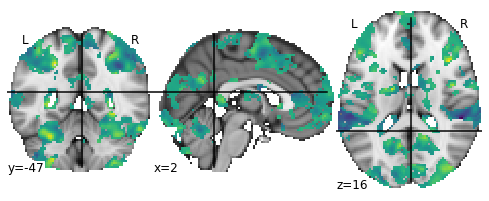

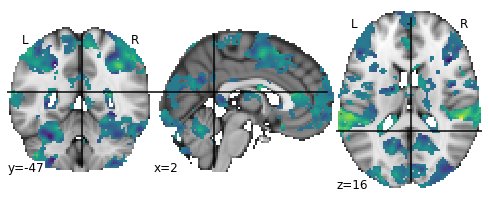

In [13]:

print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

results[3]

correct_stop_ns=results[3]['CorrectStop']
display(Markdown("### correct_stop_ns"))
plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

correct_go_ns=results[3]['CorrectGo']
display(Markdown("### correct_go_ns"))
plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

In [14]:
from analyze_results import *

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


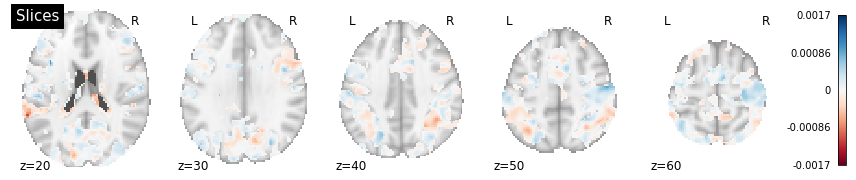

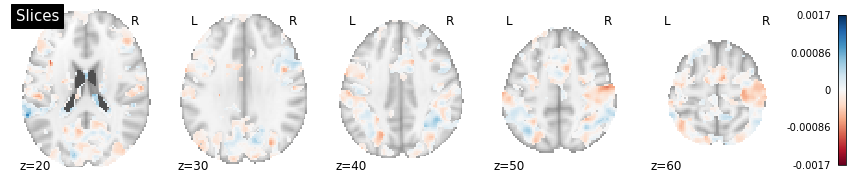

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


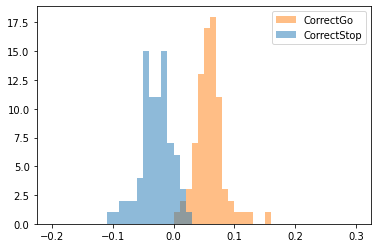

### CS_trials_CS_similarity

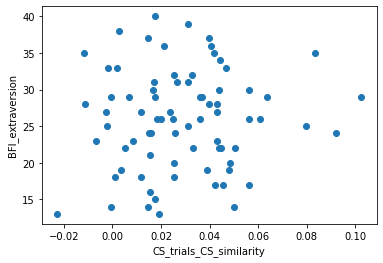

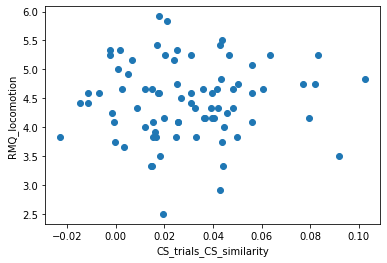

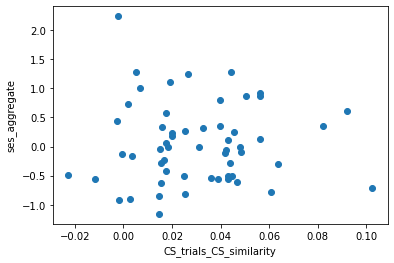

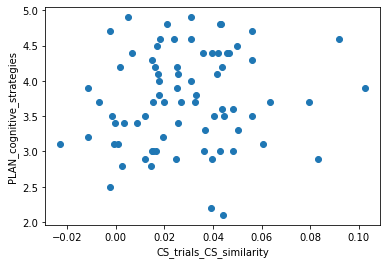

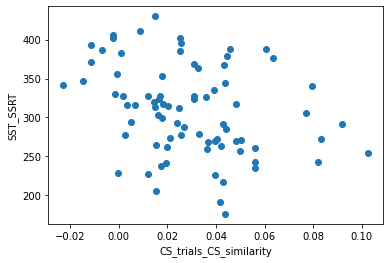

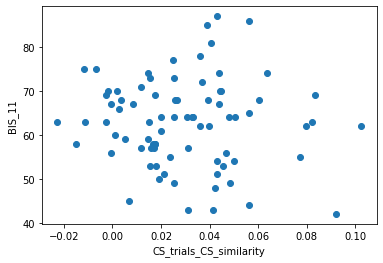

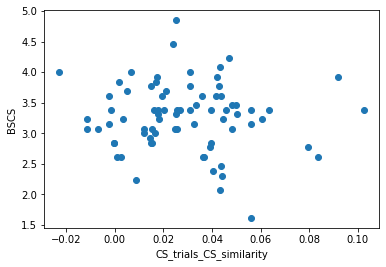

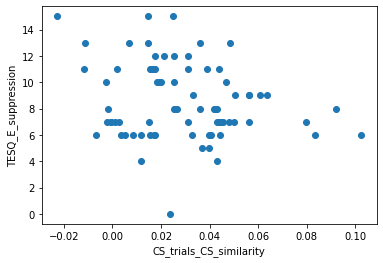

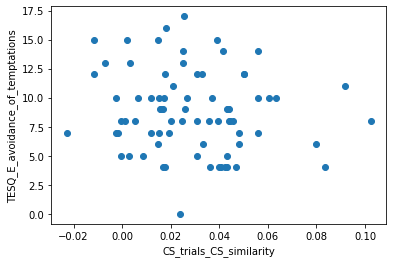

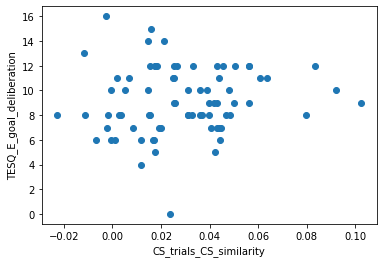

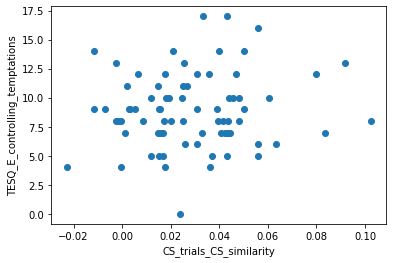

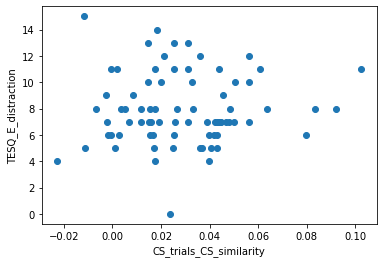

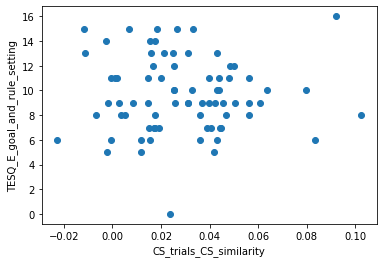

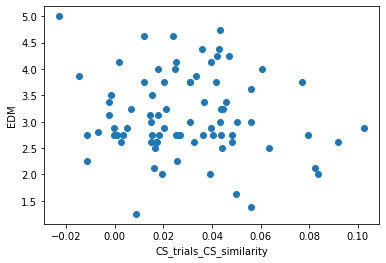

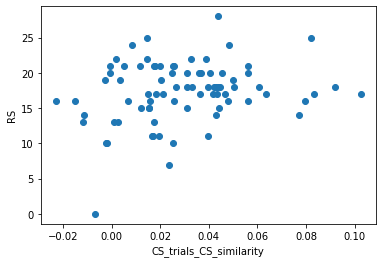

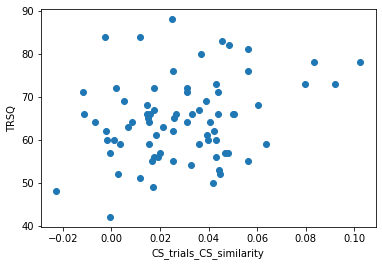

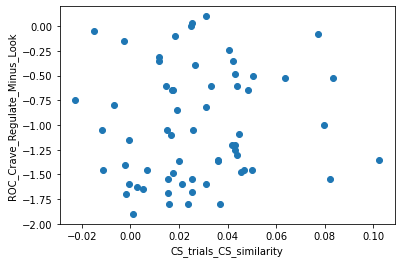

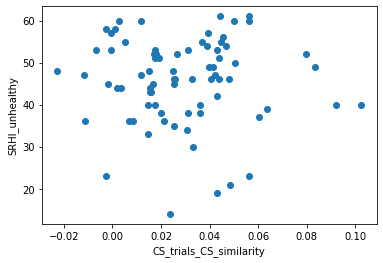

### CG_trials_CG_similarity

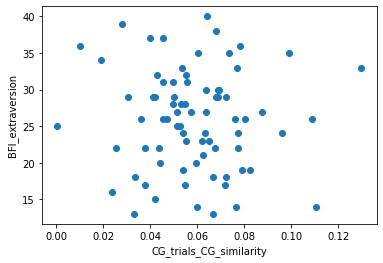

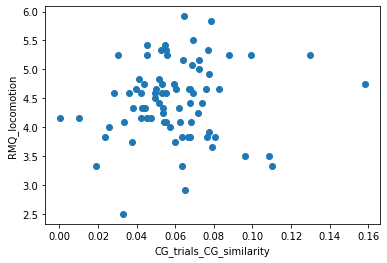

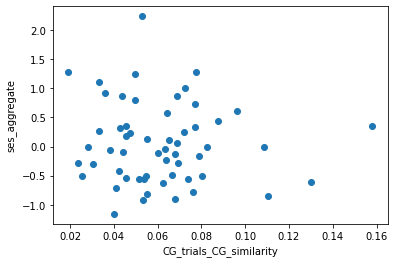

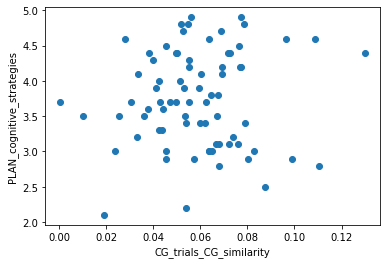

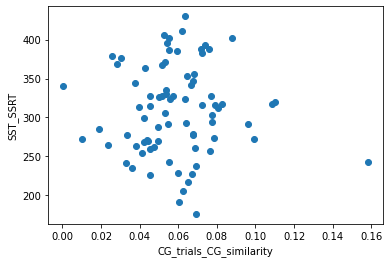

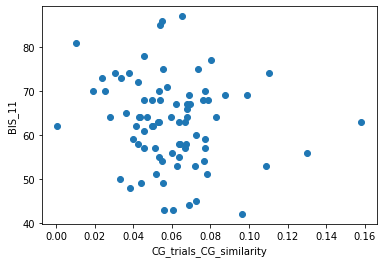

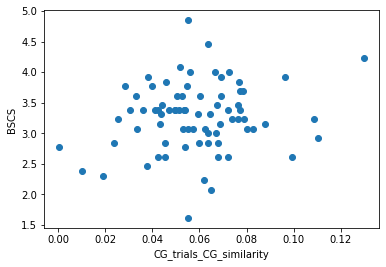

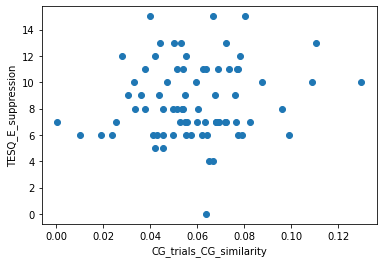

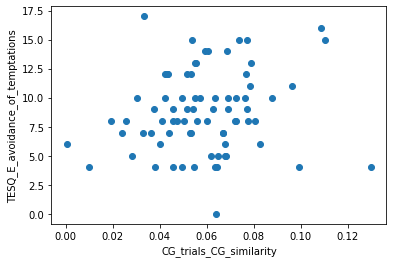

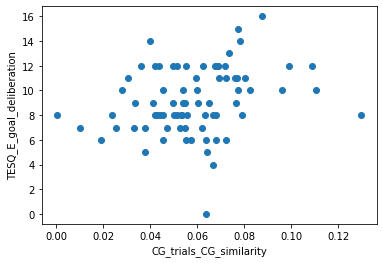

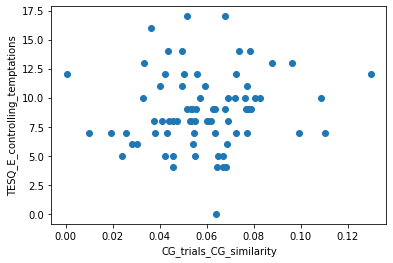

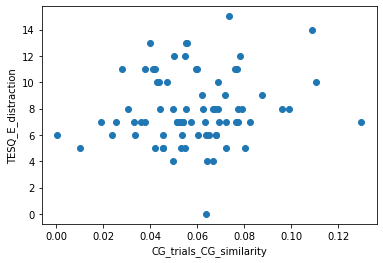

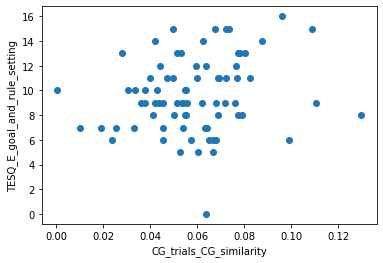

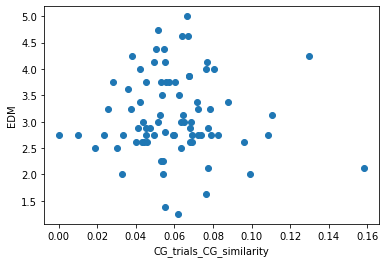

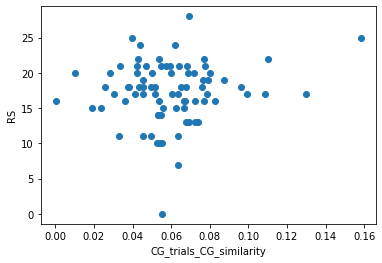

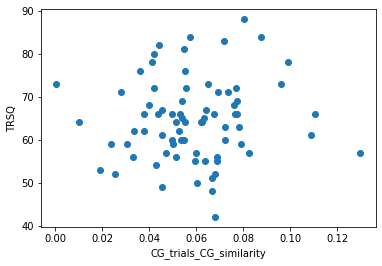

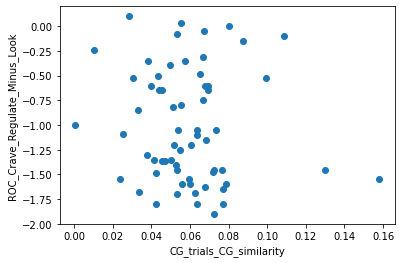

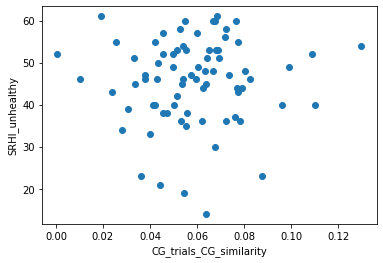

In [18]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(correct_stop_ns,correct_go_ns)

print("loading data")

bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity')

create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)

for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        visualize_corr(neural_var,correlate,ind_div_combined)
        